In [ ]:
!pip install -q transformers
!pip install japanize-matplotlib
!pip install pytorch_model_summary
!pip install torchmetrics

In [2]:
import json
import torch
from transformers import pipeline, ViTImageProcessor, ViTForImageClassification, ViTModel, AutoTokenizer, MBartModel,MBartForConditionalGeneration
import pandas as pd
from torchvision.io import read_image
from PIL import Image
from torchvision.transforms import ToTensor
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import albumentations as A
from albumentations import Compose
from skimage import io, transform
import japanize_matplotlib
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from tqdm import tqdm
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu
import string
from torchmetrics import F1Score
from typing import Optional, Tuple, Union
from transformers.modeling_outputs import Seq2SeqLMOutput

# Load data and build data class



In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data directory
annot_path = '/content/drive/MyDrive/CS263_FinalGroupProject/models/data/evjvqa_train.json'
img_zip_path = '/content/drive/MyDrive/CS263_FinalGroupProject/models/data/train-images.zip'

In [ ]:
# Open question and answering data (json)
with open(annot_path) as f:
  """
  Data file structure:
  {
    images: {
      'id': image_id
      'filename': reference file
    },
    'annotations': {
      'id': annotation_id
      'image_id': refers to id in images
      'question': question about image
      'answer': answer to question
    }
  }
  """
  train_data = json.load(f)

In [ ]:
pd.DataFrame(train_data['annotations'][0:8000])

,id,image_id,question,answer
0,0,2301,what color is the shirt of the girl wearing gl...,the girl wearing glasses wears a red shirt
1,1,2301,what fruit is put on the table next to the gir...,the girl in red t-shirt is standing next to th...
2,2,2301,what are put on the table next to the woman in...,bunches of lychee
3,3,2302,what is this woman looking at?,she is looking at the milk
4,4,2302,what is the woman in white shirt doing?,the woman in white shirt is holding and lookin...
...,...,...,...,...
7995,7995,1411,người phụ nữ mặc áo đỏ đang đứng ở quầy hàng nào?,quầy bán thịt
7996,7996,1413,hai bé gái mặc trang phục như thế nào?,áo dài màu trắng
7997,7997,1413,có bao nhiêu bé gái đang đứng bên ngoài sân?,hai bé
7998,7998,1413,hai bé gái cầm những vật gì trên tay?,"một bé cầm bông hoa, một bé mang cái giỏ"


In [5]:
# Transform for data augmentation
def get_transforms():
    list_transforms = []
    list_transforms.extend([A.Normalize(mean=0.5, std=0.5, p=1),])

    list_trfms = Compose(list_transforms)
    return list_trfms

In [6]:
# Build data class
class EVJVQA_Dataset(torch.utils.data.Dataset):
  """
  Dataset class for the EVJVQA dataset.
  """
  def __init__(self, annotation_file, img_dir, zip_subpath):
    """
    Inputs:
      annotation_file - file path for the annotation json file
      img_dir - file path for the image zip file
      zip_subpath - subfolder in the zip folder
    """
    with open(annotation_file) as f:
      json_file = json.load(f)
    self.annotations = pd.DataFrame(json_file['annotations'])
    self.img_reference = pd.DataFrame(json_file['images']).set_index('id')
    self.img_dir = img_dir
    self.transform = get_transforms()
    self.subpath = zip_subpath + '/'

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, idx):
    annot_id = self.annotations.loc[idx, 'id']
    image_id = self.annotations.loc[idx, 'image_id']
    question = self.annotations.loc[idx, 'question']
    answer = self.annotations.loc[idx, 'answer']
    img_file = self.img_reference.loc[image_id, 'filename']
    with zipfile.ZipFile(self.img_dir, 'r') as zip_ref:
       imgdata = zip_ref.open(self.subpath + img_file)
       #img = Image.open(imgdata).convert('RGB')
       img = io.imread(imgdata)[:,:,:3].astype('float32')
    size = 224
    img = transform.resize(img,(size,size))
    augmented = self.transform(image = img)
    img = augmented['image']
    img = img.transpose(2,0,1)
    img = torch.as_tensor(img, dtype=torch.float32)

    return img, question, answer

In [7]:
train_dataset = EVJVQA_Dataset(annot_path, img_zip_path, 'train-images')

In [8]:
# Utilitiy functions to show data
# Convert tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(no_):
    images, questions, answers = [],[],[]
    random_idx = np.random.choice(len(train_dataset),no_)
    for i in random_idx:
        image, question, answer = train_dataset.__getitem__(i)
        images.append(image)
        questions.append(question)
        answers.append(answer)
    plt.figure(figsize=(12,8))
    for idx in range(0,no_):
        image = image_convert(images[idx])
        plt.subplot(2,no_,idx+1)
        plt.title('Q: ' + questions[idx] + '\n A: '+ answers[idx])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

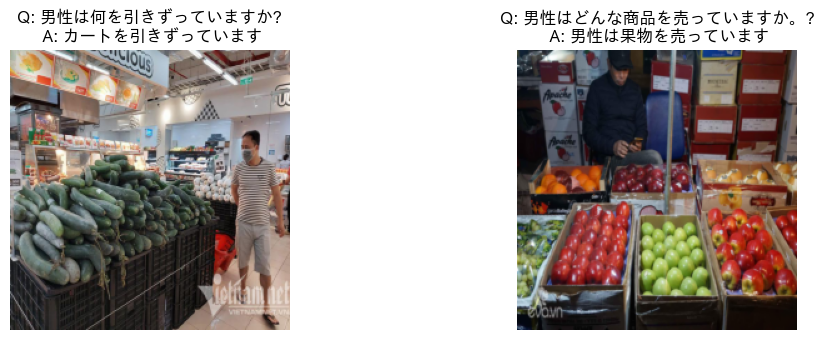

In [ ]:
plot_img(2)

# Build models

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
# Download pretrained vision transformer as image encoder
image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
image_encoder

In [11]:
# Download pretrained mBART model as text model and its tokenizer.
tokenizer = AutoTokenizer.from_pretrained("facebook/mbart-large-cc25")
text_model = MBartModel.from_pretrained("facebook/mbart-large-cc25").to(device)

Some weights of the model checkpoint at facebook/mbart-large-cc25 were not used when initializing MBartModel: ['final_logits_bias']
- This IS expected if you are initializing MBartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MBartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
text_model.config

In [12]:
# Utility function to shift token as the input (decoder_input_ids) of text decoder
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int):
    """
    Shift input ids one token to the right, and wrap the last non pad token (the <LID> token) Note that MBart does not
    have a single `decoder_start_token_id` in contrast to other Bart-like models.
    """
    prev_output_tokens = input_ids.clone()

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    prev_output_tokens.masked_fill_(prev_output_tokens == -100, pad_token_id)

    index_of_eos = (prev_output_tokens.ne(pad_token_id).sum(dim=1) - 1).unsqueeze(-1)
    decoder_start_tokens = prev_output_tokens.gather(1, index_of_eos).squeeze()
    prev_output_tokens[:, 1:] = prev_output_tokens[:, :-1].clone()
    prev_output_tokens[:, 0] = decoder_start_tokens

    return prev_output_tokens

In [13]:
# Build the mVQA model. Some of the codes are modified from the source code of mBART at hugging face.
class VQAModel2(nn.Module):
  """
  The VQAModel should consist of a image encoder and a multilingual language transformer (encoder, decoder, encoder-decoder).

  The visual_text_block is a module that integrates the encodings from the images and text.
  """

  def __init__(self, visualEncoder, textModel, vocab_size = 250027, img_hidden_dim = 768, txt_hidden_dim = 1024):
    super(VQAModel2, self).__init__()
    self.visualEncoder = visualEncoder
    self.config = textModel.config
    self.encoder = textModel.encoder
    self.decoder = textModel.decoder
    self.vocab_size = vocab_size
    # Add a linear layer to change dim of image encoding if img_hidden_dim and txt_hidden_dim do not match.
    if img_hidden_dim != txt_hidden_dim:
      self.needConvert = True
      self.dim_change = nn.Linear(img_hidden_dim, txt_hidden_dim)
    # lm_head convert text in hidden state after decoder to logits
    self.lm_head = nn.Linear(txt_hidden_dim, out_features= vocab_size, bias=False) #250027 is the vocab size for mBART
    # Cross entropy loss, ignore padding index.
    self.loss_fn = nn.CrossEntropyLoss(ignore_index = -100)
    # Logit bias of mBART
    self.register_buffer("final_logits_bias", torch.zeros((1, vocab_size)))


  def forward(
        self,
        input_ids: torch.LongTensor = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
 ):
    """
      question_input_ids - tokenized input question
      pixel_values - preprocessed image
      labels - resulting tokens from input
    """

    use_cache = use_cache if use_cache is not None else self.config.use_cache
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states)

    # Different to other models, MBart automatically creates decoder_input_ids from
    # input_ids if no decoder_input_ids are provided
    if decoder_input_ids is None and decoder_inputs_embeds is None:
        decoder_input_ids = shift_tokens_right(input_ids, self.config.pad_token_id)


    return_dict = return_dict if return_dict is not None else self.config.use_return_dict


    if encoder_outputs is None:
        encoder_outputs = self.encoder(
        input_ids=input_ids,
        attention_mask=attention_mask,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
        output_attentions=output_attentions,
        output_hidden_states=output_hidden_states,
        return_dict=return_dict,
        )

    # Image encoding
    image_encoder_outputs = self.visualEncoder(pixel_values)
    if self.needConvert:
      image_state = self.dim_change(image_encoder_outputs['last_hidden_state'])
    else:
      image_state = image_encoder_outputs['last_hidden_state']

    # Concatneante image encoding and text encoding, built relative attention mask.
    img_mask = torch.ones((image_state.shape[0], image_state.shape[1])).to(device)
    hidden_states = torch.cat([image_state, encoder_outputs[0]], dim = 1).to(device)
    attention_mask = torch.cat([img_mask, attention_mask], dim = 1).to(device)

    # Decode
    decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states = hidden_states,
            encoder_attention_mask = attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=decoder_inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

    # The logits of generated answer, in the shape of BatchNumber * hidden_state_size * vocab_size
    lm_logits = self.lm_head(decoder_outputs[0]) + self.final_logits_bias

    out = {
            "logits": lm_logits,
            "hidden_states": decoder_outputs['last_hidden_state']
        }

    # Calculate cross entropy loss (need to ignore paddings).
    if labels is not None:
        labels = labels.to(lm_logits.device)
        loss = self.loss_fn(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
        out["loss"] = loss

    return out

In [14]:
model = VQAModel2(image_encoder, text_model).to(device)

In [84]:
from pytorch_model_summary import summary
print(summary(model, torch.zeros((2,60)).long().to(device),
              torch.zeros((2,3,224,224)).to(device),
              torch.zeros((2,60)).long().to(device),
              torch.zeros((2,60)).long().to(device),
              show_input=True))

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
    MBartEncoder-1                          408,237,056     408,237,056
        ViTModel-2     [2, 3, 224, 224]      86,389,248      86,389,248
          Linear-3        [2, 197, 768]         787,456         787,456
    MBartDecoder-4                          458,642,432     458,642,432
          Linear-5        [2, 60, 1024]     256,027,648     256,027,648
Total params: 1,210,083,840
Trainable params: 1,210,083,840
Non-trainable params: 0
------------------------------------------------------------------------


# Training

In [15]:
# Collate_fn class for data loader using tokenizer
class MultimodalCollator:
  tokenizer: AutoTokenizer
  def __init__(self, tokenizer):
    self.tokenizer = tokenizer

  def tokenize_text(self, texts):

      encoded_text = self.tokenizer(
          text=texts,
          max_length = 60,
          padding='max_length',
          return_tensors='pt',
          return_attention_mask=True)
      return {
          "input_ids": encoded_text['input_ids'].squeeze(),
          "attention_mask": encoded_text['attention_mask'].squeeze()
      }

  def tokenize_answer(self, texts):

      encoded_text = self.tokenizer(
          text=texts,
          max_length = 60,
          padding='max_length',
          return_tensors='pt',
          return_attention_mask=True)

      encoded_text['input_ids'][encoded_text['input_ids'] == 1] = -100
      return {
          "labels": encoded_text['input_ids'].squeeze(),
      }

  def preprocess_images(self, images):
      return {
          "pixel_values": images}

  def __call__(self, examples):
      return {
          **self.tokenize_text(
              examples[1] if isinstance(examples, tuple) else [i[1] for i in examples]
          ),
           **self.tokenize_answer(
              examples[2] if isinstance(examples, tuple) else [i[2] for i in examples]
          ),
          **self.preprocess_images(
              examples[0] if isinstance(examples, tuple) else torch.stack([i[0] for i in examples])
          )
      }

In [16]:
collate_fn = MultimodalCollator(tokenizer)

In [17]:
# Build the dataloaders
# split the training and validation dataset to around 0.7 train and 0.3 test
generator1 = torch.Generator().manual_seed(2023)
trainset, test_dataset_sub = random_split(train_dataset, [16650, 7135],generator=generator1)
train_dataset_sub, val_dataset_sub = random_split(trainset, [13320, 3330],generator=generator1)

# build train dataloader
train_loader = DataLoader(dataset=train_dataset_sub, batch_size=16, shuffle = True, num_workers = 0, collate_fn = collate_fn)

# build validation dataloader
val_loader = DataLoader(dataset=val_dataset_sub, batch_size=16, shuffle = False, num_workers = 0, collate_fn = collate_fn)

In [18]:
# Setting up training parameters
num_epochs = 12
learning_rate = 1e-5
scale = 1
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index = -100)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.5)

In [19]:
# Directory to save checkpoints
model_outputs = "drive/MyDrive/CS263_FinalGroupProject/models/vit_mbart_checkpoints_model2"

In [20]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, scheduler):
  train_loss = []
  val_loss = []
  train_f1 = []
  val_f1 = []
  for epoch in range(num_epochs):
      running_train_loss, running_train_f1 = [],[]
      running_val_loss,running_val_f1 = [],[]
      model.train()
      for i, (batch_dict) in tqdm(enumerate(train_loader)):
        # Move the inputs and targets to the device (CPU or GPU)
          input_ids = batch_dict['input_ids'].to(device)
          pixel_values = batch_dict['pixel_values'].to(device)
          attention_mask = batch_dict['attention_mask'].to(device)
          labels = batch_dict['labels'].to(device)

          optimizer.zero_grad()

          # Forward pass
          outputs = model(input_ids, pixel_values, attention_mask, labels = labels)
          #print("logit shape: ", outputs['logits'].shape)

          # Compute the loss
          #loss = criterion(outputs['logits'].float(),answers.float()).float()
          loss = outputs['loss']
          print('loss: ', loss.item())
          running_train_loss.append(loss.item())

          # Compute f1_score
          f1 = F1Score(task="multiclass", num_classes=250027, topk = 1, ignore_index = -100).to(device)
          s = f1(outputs['logits'].argmax(dim = 2), labels)
          running_train_f1.append(s.clone().cpu().numpy())
          print('f1_score: ', s.clone().cpu().numpy())


          # Backward pass and optimization
          loss.backward()
          optimizer.step()

      # Use learning scheduler
      scheduler.step()

      # Test on validation dataset
      model.eval()
      with torch.no_grad():
        for batch_dict in val_loader:
            input_ids = batch_dict['input_ids'].to(device)
            pixel_values = batch_dict['pixel_values'].to(device)
            attention_mask = batch_dict['attention_mask'].to(device)
            labels = batch_dict['labels'].to(device)

            outputs = model(input_ids, pixel_values, attention_mask)

            lm_logits = outputs['logits']
            labels = labels.to(lm_logits.device)
            loss = criterion(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
            #loss = criterion(outputs['logits'].float(),labels.float())
            running_val_loss.append(loss.item())

            # Compute f1_score
            f1 = F1Score(task="multiclass", num_classes=250027, topk = 1, ignore_index = -100).to(device)
            s = f1(lm_logits.argmax(dim = 2), labels)
            running_val_f1.append(s.clone().cpu().numpy())
            print('val_f1_score: ', s.clone().cpu().numpy())

      # Print loss
      epoch_train_loss = np.mean(running_train_loss)
      epoch_train_f1 = np.mean(running_train_f1)
      print("Epoch [{}/{}], Train Loss: {:.4f}, Train F1: {:.4f}, LearningRate: {} ".format(epoch+1, num_epochs, epoch_train_loss, epoch_train_f1, scheduler.get_lr() ))
      train_loss.append(epoch_train_loss)
      train_f1.append(epoch_train_f1)

      epoch_val_loss = np.mean(running_val_loss)
      epoch_val_f1 = np.mean(running_val_f1)
      print("Epoch [{}/{}], Val Loss: {:.4f}, Val F1: {:.4f}".format(epoch+1, num_epochs, epoch_val_loss, epoch_val_f1))
      val_loss.append(epoch_val_loss)
      val_f1.append(epoch_val_f1)

      # Save the trained model
      if (epoch+1) > 0:
        torch.save(model.state_dict(), model_outputs + "/ViTmBART_epoch" + str(epoch+19) + ".pth")

  return model, train_loss, val_loss, train_f1, val_f1

In [ ]:
# build small data for test
train_dataset_small = Subset(train_dataset_sub, [0,1,2,3])
val_dataset_small = Subset(val_dataset_sub, [0,1,2,3])

train_loader_small = DataLoader(dataset=train_dataset_small, batch_size=2, shuffle = True, num_workers = 0, collate_fn = collate_fn)
val_loader_small = DataLoader(dataset=val_dataset_small, batch_size=2, shuffle = False, num_workers = 0, collate_fn = collate_fn)

In [21]:
# Load checkpoint
checkpoint_best = torch.load(model_outputs + "/ViTmBART_epoch29.pth")
model.load_state_dict(checkpoint_best)

<All keys matched successfully>

In [ ]:
# Train model
model, train_loss, val_loss, train_f1, val_f1 = train(model, train_loader, val_loader, optimizer, criterion, num_epochs, lr_scheduler)

# Evaluation

In [ ]:
!pip install langdetect

In [23]:
from torchmetrics import F1Score
from nltk.translate import bleu
from nltk.translate.bleu_score import SmoothingFunction
from langdetect import detect
smoothie = SmoothingFunction().method4

In [24]:
# Build bleu evaluation metric
def bleu_score(reference, candidate):
  # ignore punctuations
  reference = reference.translate(str.maketrans('', '', string.punctuation))
  candidate = candidate.translate(str.maketrans('', '', string.punctuation))
  ref_list, can_list = [],[]
  # convert string to list of words
  try:
      lang = detect(reference)
  except:
      lang = "error"
      print("error for detecting: ", reference)
  # Detect if the language is Japanese, whose words in answers are not split by space.
  # Need to make it a list of characters for bleu score calculation.
  if lang != "en" or lang != "vi":
    # ignore possible spaces in Japanese sentences
    reference = reference.replace(" ", "")
    candidate = candidate.replace(" ", "")
    for ch in reference:
      ref_list.append(ch)
    for ch in candidate:
      can_list.append(ch)
  else:
    ref_list = reference.split()
    can_list = candidate.split()

  score = bleu([ref_list], can_list,smoothing_function=smoothie, weights = [0.25,0.25,0.25,0.25])
  return score

In [25]:
# Evaluate model performance on test dataset
def test_eval(test_data, model):
  f1_torchmetric, bleu_l, pred_token_l, pred_word_l = [],[],[],[]
  f1_en, f1_ja, f1_vi = [],[],[]
  bleu_en, bleu_ja, bleu_vi = [],[],[]

  model.eval()
  with torch.no_grad():
    for i in range(len(test_data)):
      image, question, answer = test_data.__getitem__(i)
      image = image.to(device)

      question_tok = tokenizer(question, max_length = 60, padding='max_length',return_tensors="pt", return_attention_mask = True)
      input_ids = question_tok["input_ids"].to(device)
      attention_mask = question_tok["attention_mask"].to(device)
      answer_tok = tokenizer(answer, max_length = 60, padding='max_length',return_tensors="pt")['input_ids']
      answer_tok[answer_tok == 1] = -100
      answer_tok = answer_tok.to(device)
      output = model(input_ids = input_ids, pixel_values = image.unsqueeze(0), attention_mask = attention_mask)

      logit = output['logits']
      pred = logit.argmax(dim =2)
      pred_token_l.append(pred.clone().cpu())
      pred_word = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
      pred_word_l.append(pred_word)

      # F1 score from torch.metric
      f1 = F1Score(task="multiclass", num_classes=250027, topk = 1, ignore_index = -100).to(device)
      s3 = f1(pred, answer_tok)
      f1_torchmetric.append(s3)

      # Compute bleu score
      s2 = bleu_score(answer,pred_word)
      bleu_l.append(s2)

      try:
        lang = detect(answer)
      except:
        lang = "error"
        #print("error for detecting: ", answer)
      if lang == "en":
        f1_en.append(s3)
        bleu_en.append(s2)
      elif lang == "vi":
        f1_vi.append(s3)
        bleu_vi.append(s2)
      else:
        f1_ja.append(s3)
        bleu_ja.append(s2)


  return f1_torchmetric, bleu_l, pred_token_l, pred_word_l, f1_en, f1_ja, f1_vi, bleu_en, bleu_ja, bleu_vi

In [ ]:
f1_torchmetric, bleu_l, pred_token_l, pred_word_l, f1_en, f1_ja, f1_vi, bleu_en, bleu_ja, bleu_vi = test_eval(test_dataset_sub,model)

In [27]:
print("average f1 score: ", sum(f1_torchmetric)/len(f1_torchmetric))
print("average f1 score in en: ", sum(f1_en)/len(f1_en))
print("average f1 score in ja: ", sum(f1_ja)/len(f1_ja))
print("average f1 score in vi: ", sum(f1_vi)/len(f1_vi))
print("average bleu score: ", sum(bleu_l)/len(bleu_l))
print("average bleu score in en: ", sum(bleu_en)/len(bleu_en))
print("average bleu score in ja: ", sum(bleu_ja)/len(bleu_ja))
print("average bleu score in vi: ", sum(bleu_vi)/len(bleu_vi))

average f1 score:  tensor(0.3427, device='cuda:0')
average f1 score in en:  tensor(0.2887, device='cuda:0')
average f1 score in ja:  tensor(0.3378, device='cuda:0')
average f1 score in vi:  tensor(0.3866, device='cuda:0')
average bleu score:  0.23693787290005747
average bleu score in en:  0.212807306104512
average bleu score in ja:  0.15530665040118477
average bleu score in vi:  0.35081947202662583


In [28]:
# Utility function to visualize result
def plot_img_test(no_, dataset):
    images, questions, answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst = [],[],[],[],[],[],[],[]
    random_idx = np.random.choice(len(dataset),no_)
    for i in random_idx:
        image, question, answer = dataset.__getitem__(i)
        images.append(image)
        questions.append(question)
        answers.append(answer)

        question_tok = tokenizer(question, max_length = 60, padding='max_length',return_tensors="pt", return_attention_mask = True)
        input_ids = question_tok["input_ids"].to(device)
        attention_mask = question_tok["attention_mask"].to(device)
        answer_tok = tokenizer(answer, max_length = 60, padding='max_length',return_tensors="pt")["input_ids"].to(device)
        answer_tokens.append(answer_tok)
        answer_tok[answer_tok == 1] = -100

        output = model(input_ids, pixel_values = image.unsqueeze(0).to(device), attention_mask = attention_mask)
        logit = output['logits']
        pred = logit.argmax(dim =2)
        pred_tokens.append(pred)
        pred_word = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(pred_word)

        pred[pred == 1] = -100
        f1 = F1Score(task="multiclass", num_classes=250027, topk = 1, ignore_index = -100).to(device)
        s3 = f1(pred, answer_tok)
        f1_tm_lst.append(s3)
        s2 = bleu_score(answer,pred_word)
        bleu_lst.append(s2)

        print('\n Q: ' + question + '\n A: '+ answer + '\n Pred: '+ pred_word)

    print("\n F1 torchmetric",f1_tm_lst)
    print("\n Bleu_score",bleu_lst)


    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
        image = image_convert(images[idx])
        plt.subplot(1, no_, idx+1)
        plt.imshow(image)
        plt.rcParams.update({'font.size': 8})
        plt.title('Q: ' + questions[idx] + '\n A: '+ answers[idx] + '\n Pred: '+ predictions[idx] + '\n')
        plt.axis('off')
        plt.subplots_adjust(left=0.1,
                      bottom=0.1,
                      right=0.9,
                      top=0.9,
                      wspace=1.8,
                      hspace=1.8)
    plt.show()

    return answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst

In [ ]:
answers, answer_tokens, predictions, pred_tokens, f1_tm_lst, bleu_lst = plot_img_test(3,test_dataset_sub)